In [1]:
import scvi
import scrnatools as rna
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_context("paper")
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False

Data paths

In [3]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [4]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [5]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/combined_all_genes", adata=adata)

INFO     File /mnt/iacchus/joe/processed_data//Fezf2_thymus_paper/scVI_models/combined_all_genes/model.pt already  
         downloaded                                                                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
exprs = pd.DataFrame(adata[adata.obs.genotype == "WT"].layers["scVI_normalized"], index=adata[adata.obs.genotype == "WT"].obs_names)
exprs["cell_type"] = adata.obs.majority_voting
exprs = exprs.groupby("cell_type").mean()

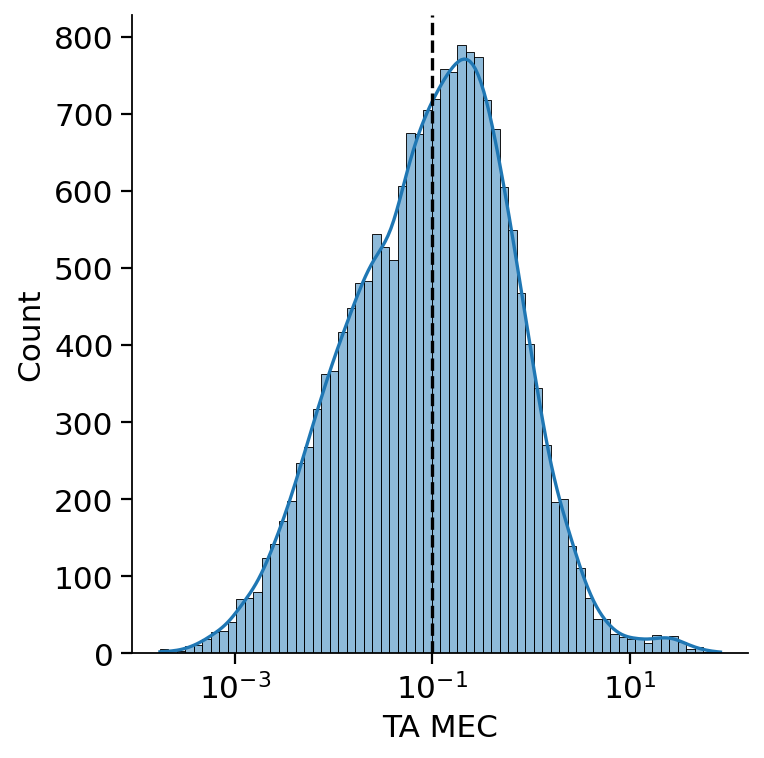

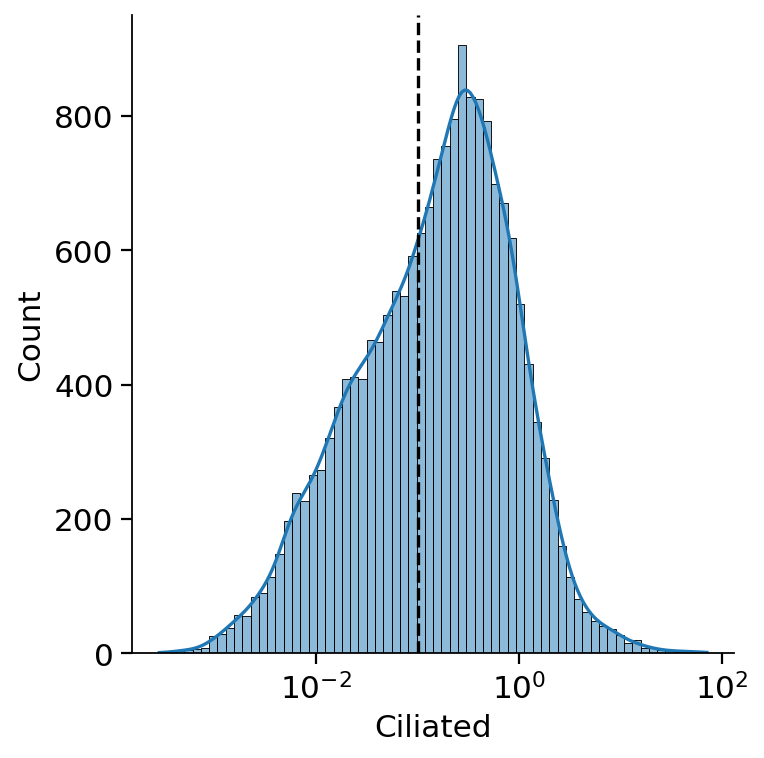

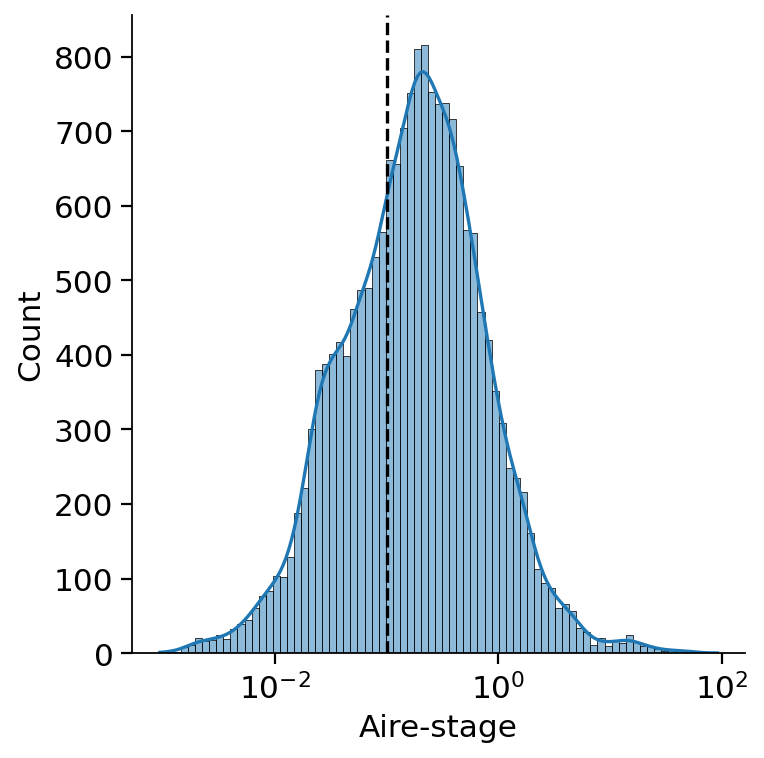

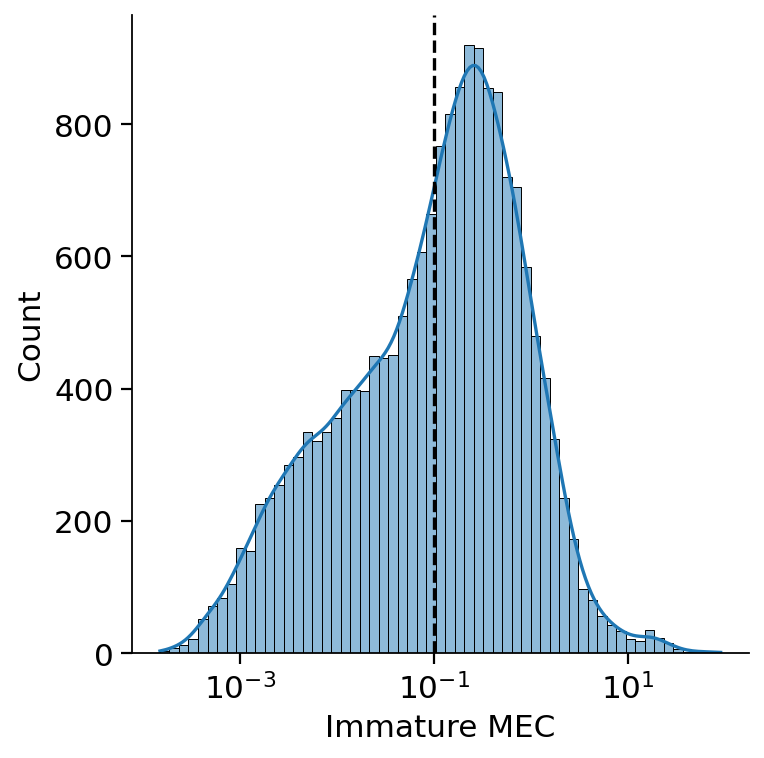

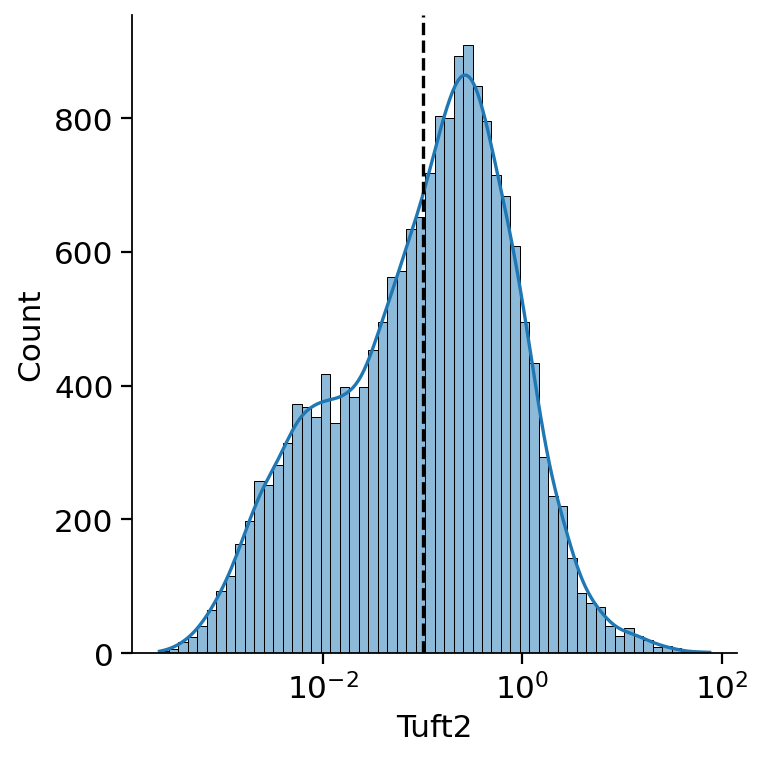

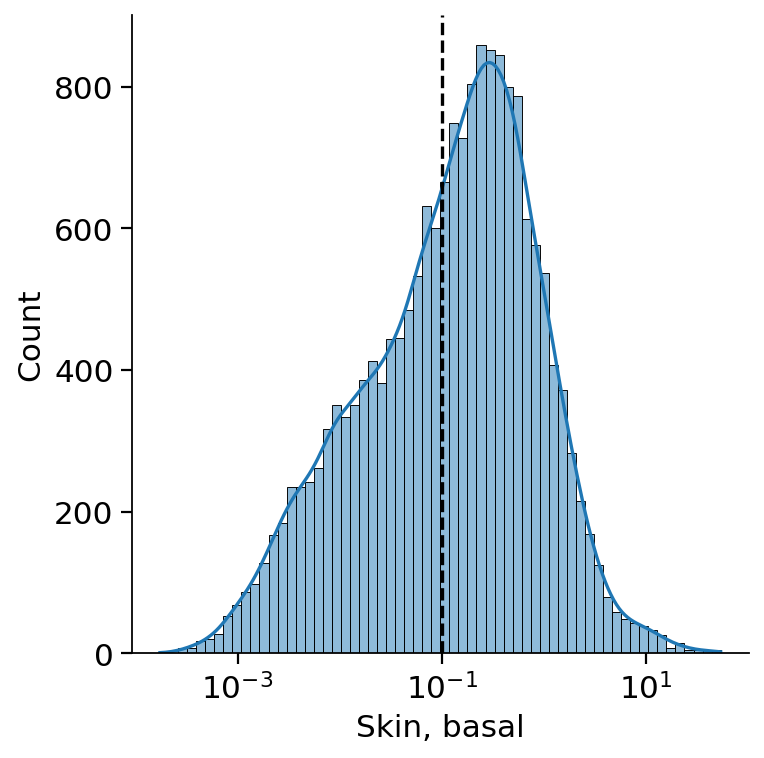

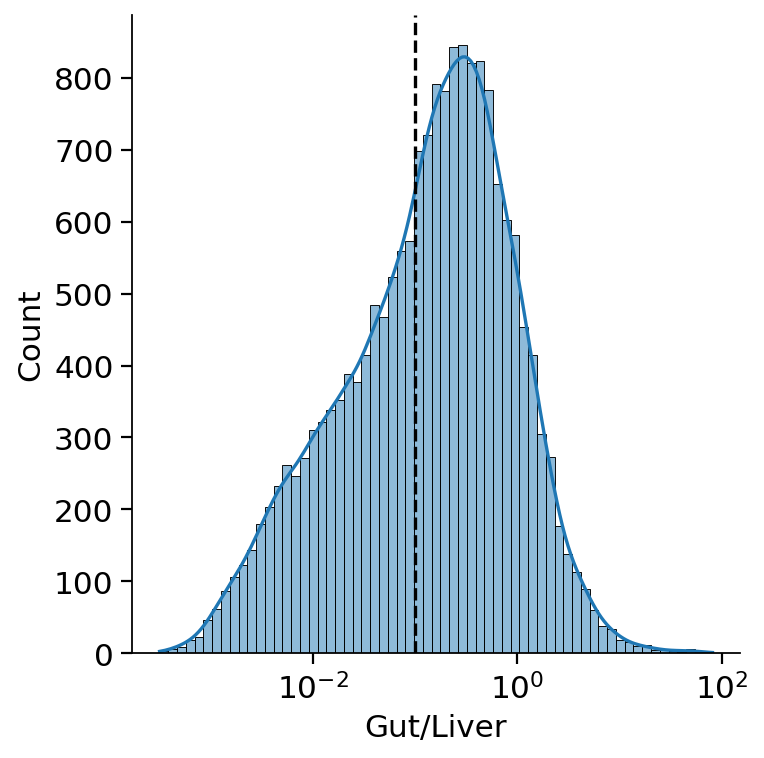

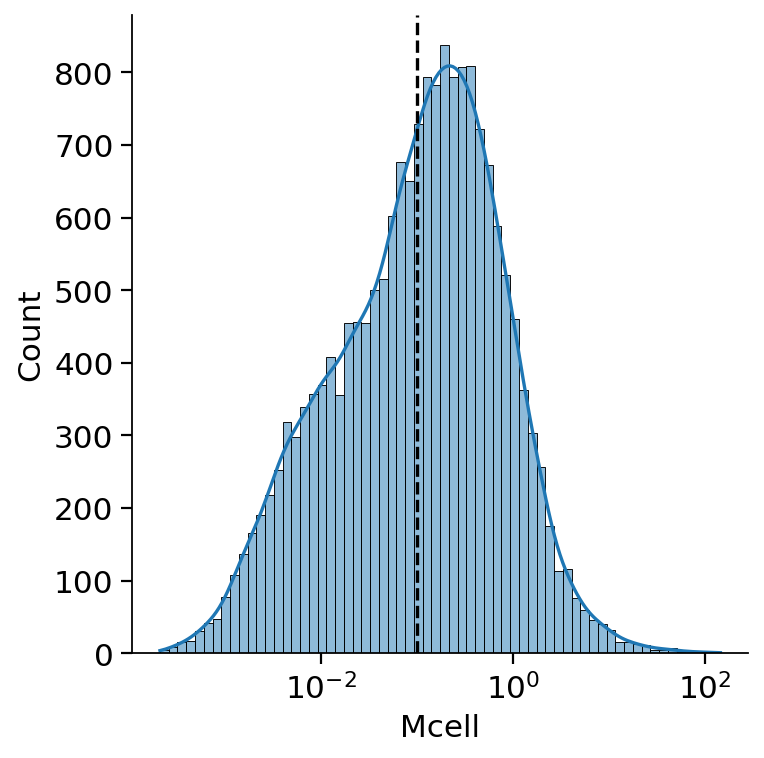

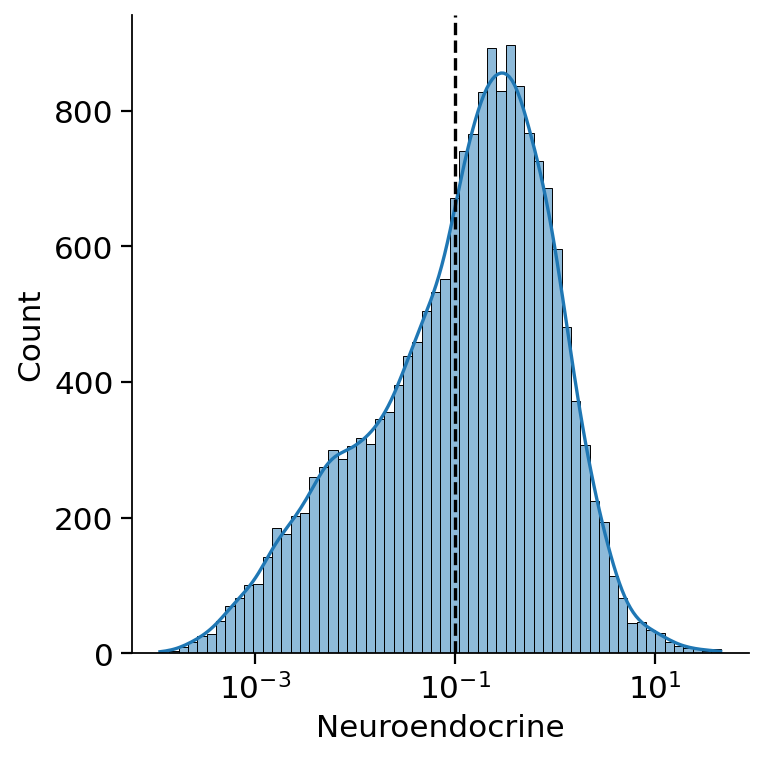

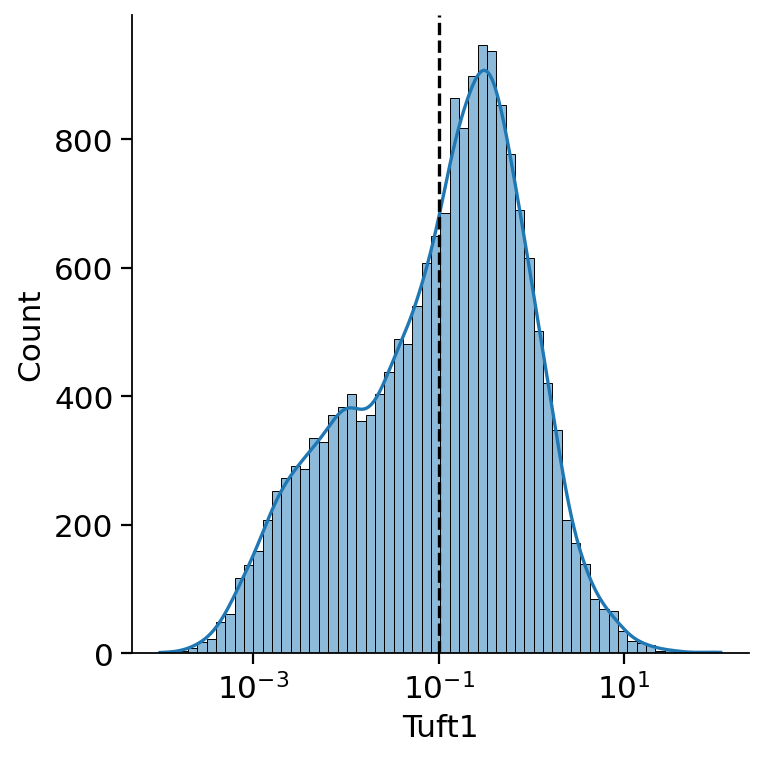

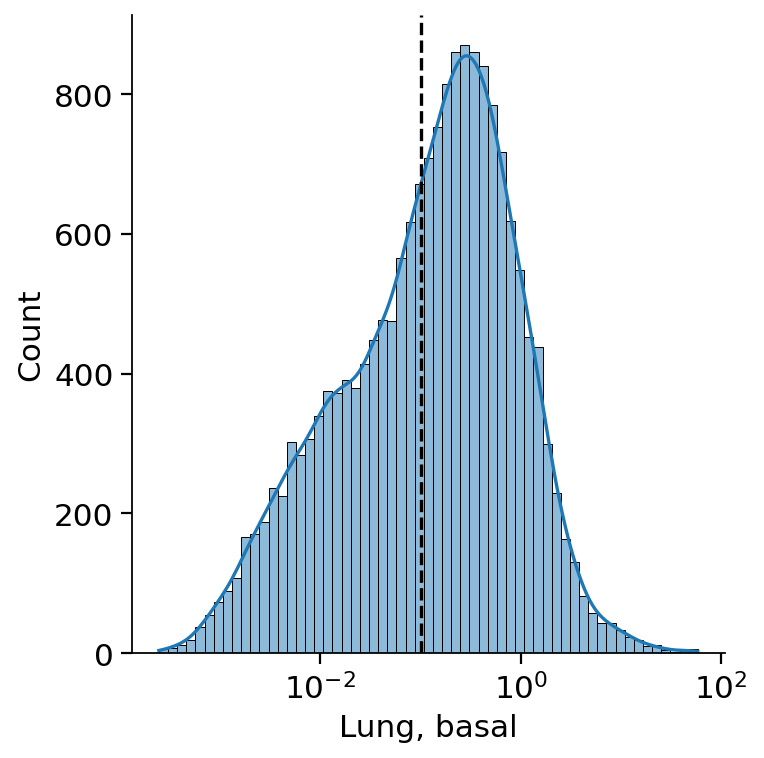

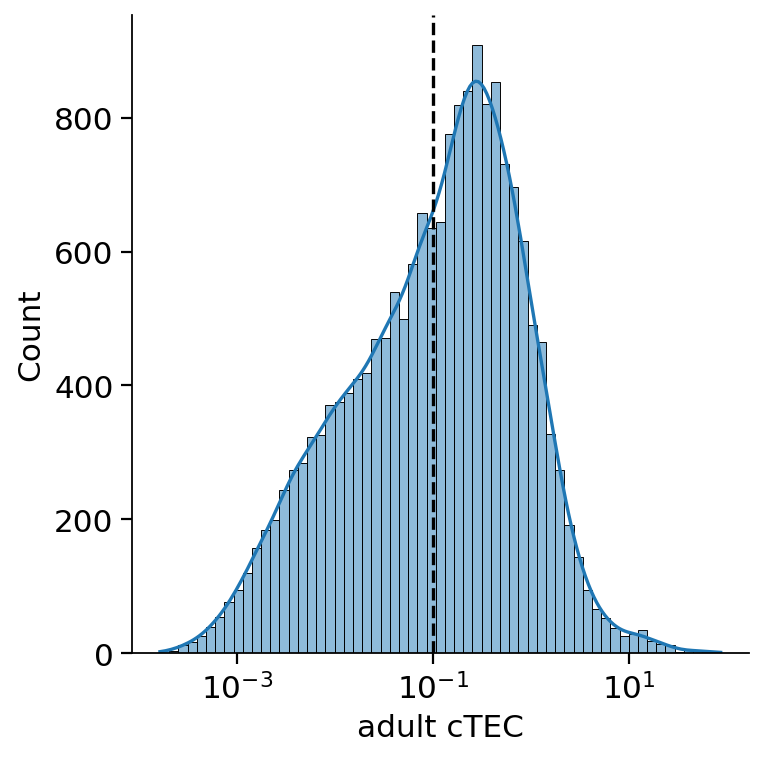

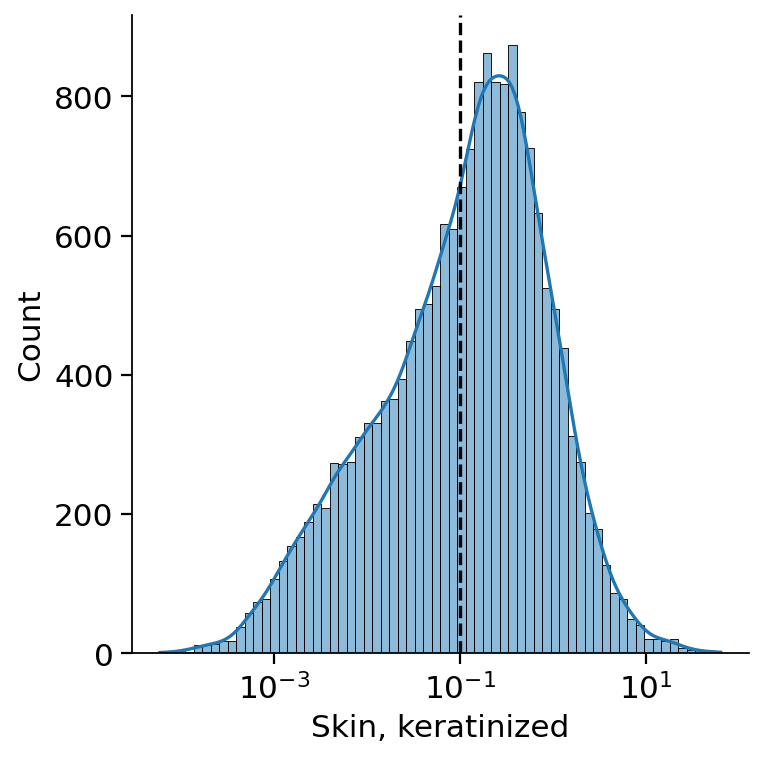

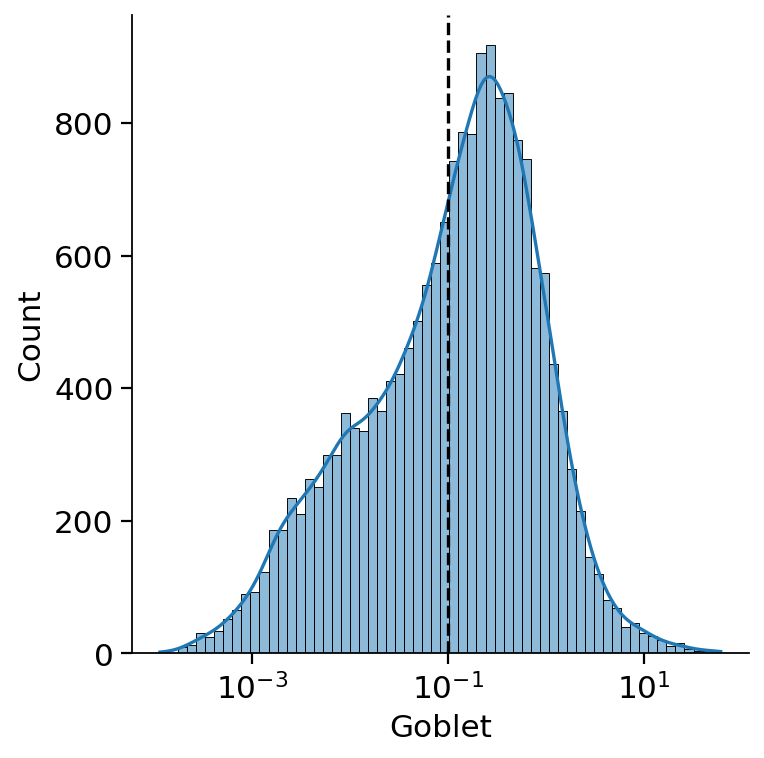

In [7]:
for cell_type in adata.obs.majority_voting.unique():
    sns.displot(exprs.T[cell_type], log_scale=True, kde=True)
    plt.axvline(x=0.1, color="black", linestyle="--")
    plt.show()

In [8]:
exprs = pd.DataFrame(adata.layers["scVI_normalized"], index=adata.obs_names)
exprs = exprs > 0.1
exprs = pd.DataFrame(exprs.sum(axis=1))
exprs["cell_type"] = adata.obs.majority_voting
exprs["genotype"] = adata.obs.genotype

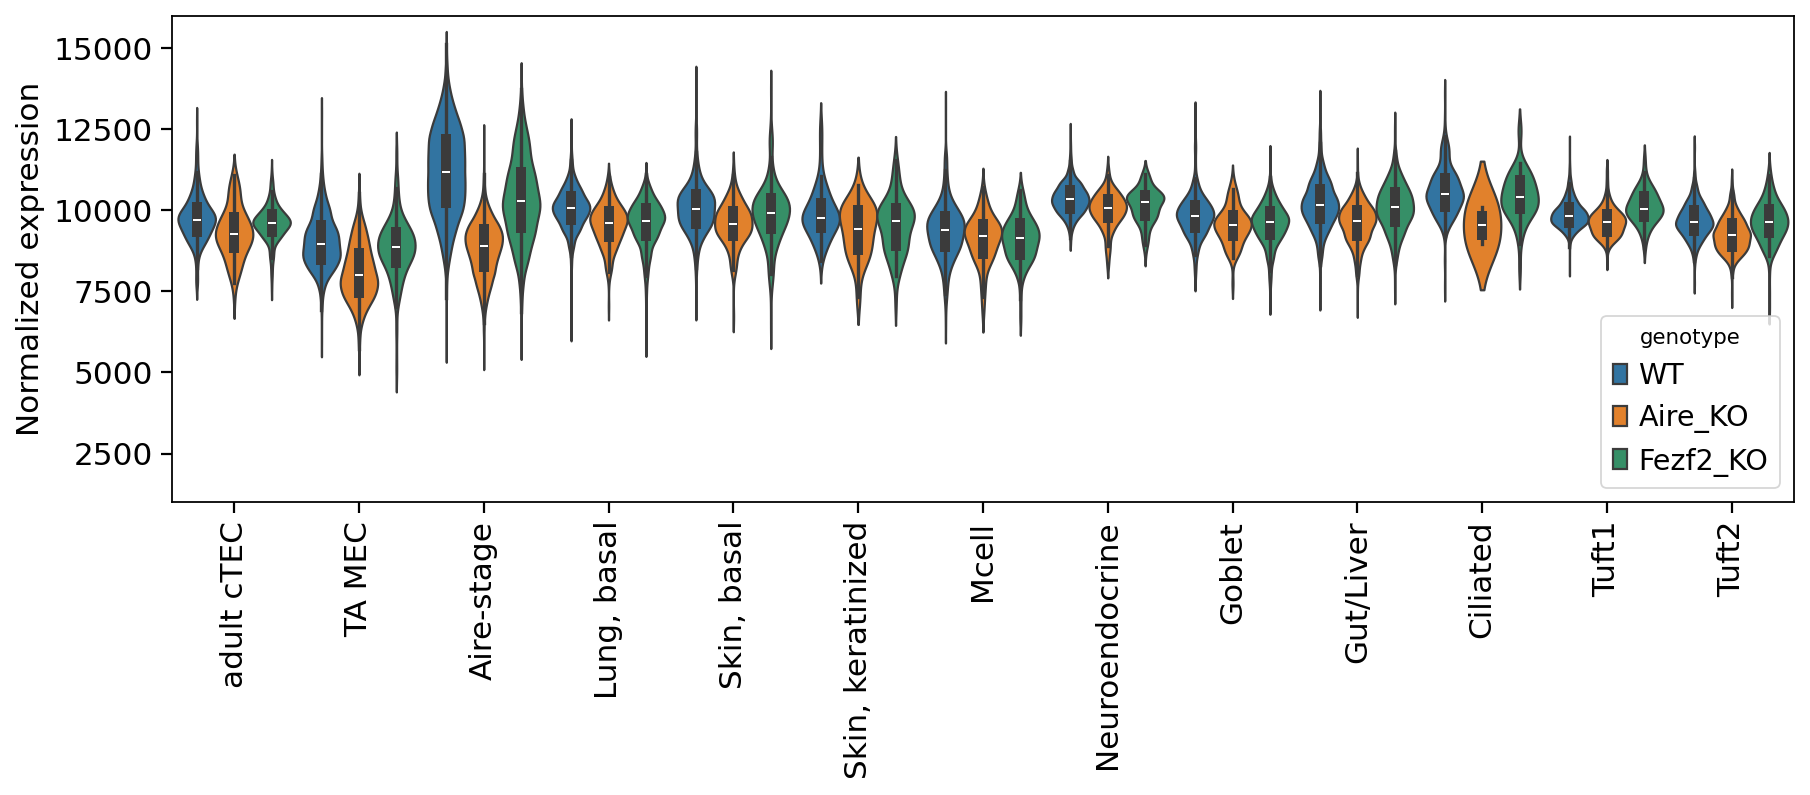

In [9]:
plt.figure(figsize=(13,4))
sns.violinplot(
    exprs,
    x="cell_type",
    y=0,
    hue="genotype",
    density_norm='width',
    width=0.9,
    hue_order=["WT", "Aire_KO", "Fezf2_KO"],
    order=["adult cTEC", "TA MEC", "Aire-stage", "Lung, basal",
           "Skin, basal", "Skin, keratinized", "Mcell", "Neuroendocrine", "Goblet",
           "Gut/Liver", "Ciliated", "Tuft1", "Tuft2"]
)
plt.xlabel("")
plt.ylabel("Normalized expression")
plt.xticks(rotation=90)
plt.ylim(1000, 16000)
plt.show()

# Cell x gene epithelial cells

In [13]:
cell_x_gene_exprs = np.load(f"{processedDataPath}cell_x_gene_atlas/expression/cell_x_gene_atlas_cell_type_expression.npy")
genes = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/keep_genes.csv")["feature_name"]
index = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/cell_type_index.csv")["cell_type"]
cell_x_gene_exprs = pd.DataFrame(cell_x_gene_exprs, index=index, columns=genes)

In [15]:
cell_x_gene_exprs = cell_x_gene_exprs[cell_x_gene_exprs.index.str.contains("epithelial")]
cell_x_gene_exprs = cell_x_gene_exprs > 0.1
cell_x_gene_exprs = pd.DataFrame(cell_x_gene_exprs.sum(axis=1))

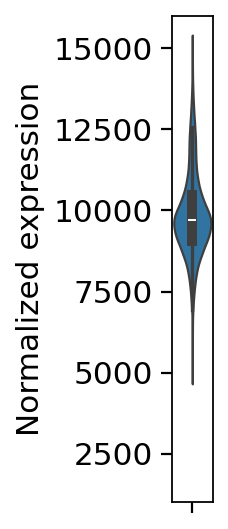

In [16]:
plt.figure(figsize=(0.33,4))
sns.violinplot(
    exprs,
    y=0,
    density_norm='width',
    width=0.9,
)
plt.ylim(1000, 16000)
plt.xlabel("")
plt.ylabel("Normalized expression")
plt.xticks(rotation=90)
plt.show()

In [17]:
cell_x_gene_exprs.to_csv("../analysis/cell_x_gene_epithelial_num_genes_expressed.csv")